# Parameter Estimation for Energy Model of EGFR Pathway

In [1]:
import petab
import fides
import os
import libsbml
import amici
import amici.petab_simulate
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import petab.visualize
import pypesto.visualize as visualize
from petab.visualize import plot_data_and_simulation
from petab.visualize import plot_petab_problem
import importlib
import sys

In [2]:
# import to petab
petab_problem = petab.Problem.from_yaml(
    
   "EGFR/EGFR.yaml"    #state the exact folder contains the yaml file
)
importer = pypesto.petab.PetabImporter(petab_problem)
# import to pypesto
problem = importer.create_problem()
model = importer.create_model(verbose=False)


Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.
Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.


In [3]:

# create optimizer object which contains all information for doing the optimization
options = {'maxiter':2000}
optimizer = optimize.FidesOptimizer(options=options)
#optimizer = optimize.PyswarmOptimizer(options=options)
#optimizer = optimize.ScipyOptimizer()
#engine = pypesto.engine.SingleCoreEngine()
engine = pypesto.engine.MultiProcessEngine()

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=5, engine=engine
)


Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 5 processes.
100%|██████████| 5/5 [00:00<00:00, 142.55it/s]Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.
Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.

Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.
Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.
Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.
2022-07-12 08:56:16 fides(INFO) iter|    fval   |   

# Visualization

<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

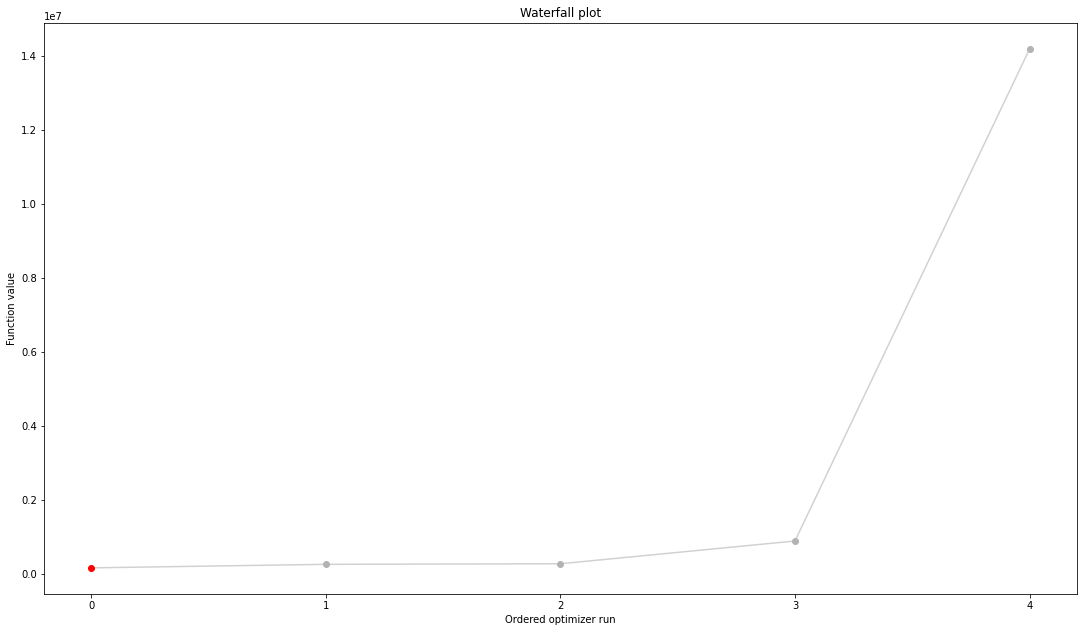

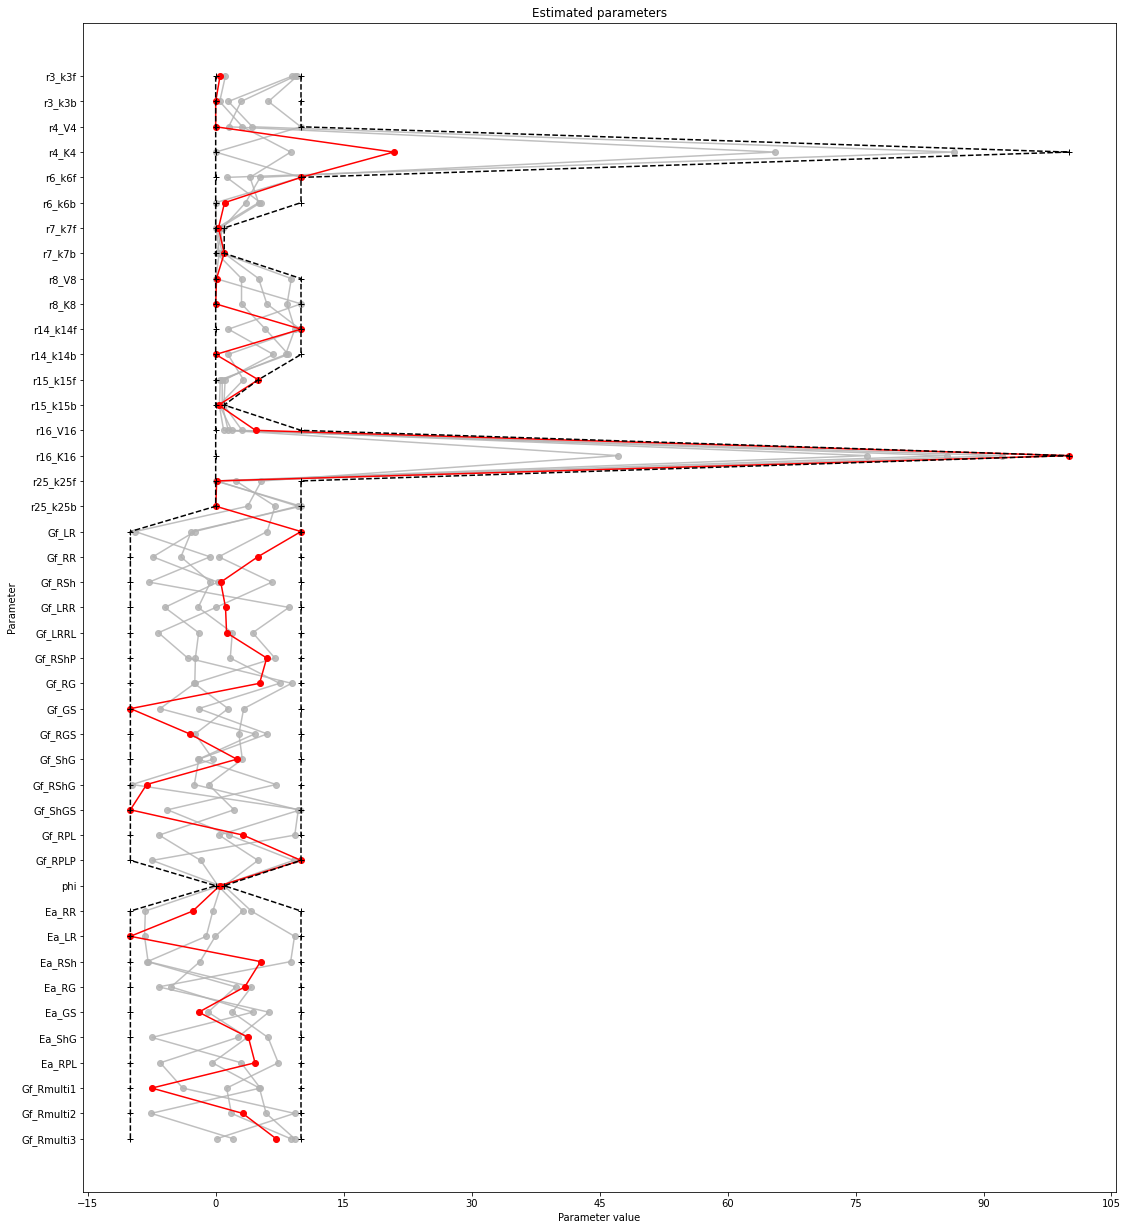

In [4]:
visualize.waterfall(result, scale_y="lin")
visualize.parameters(result)

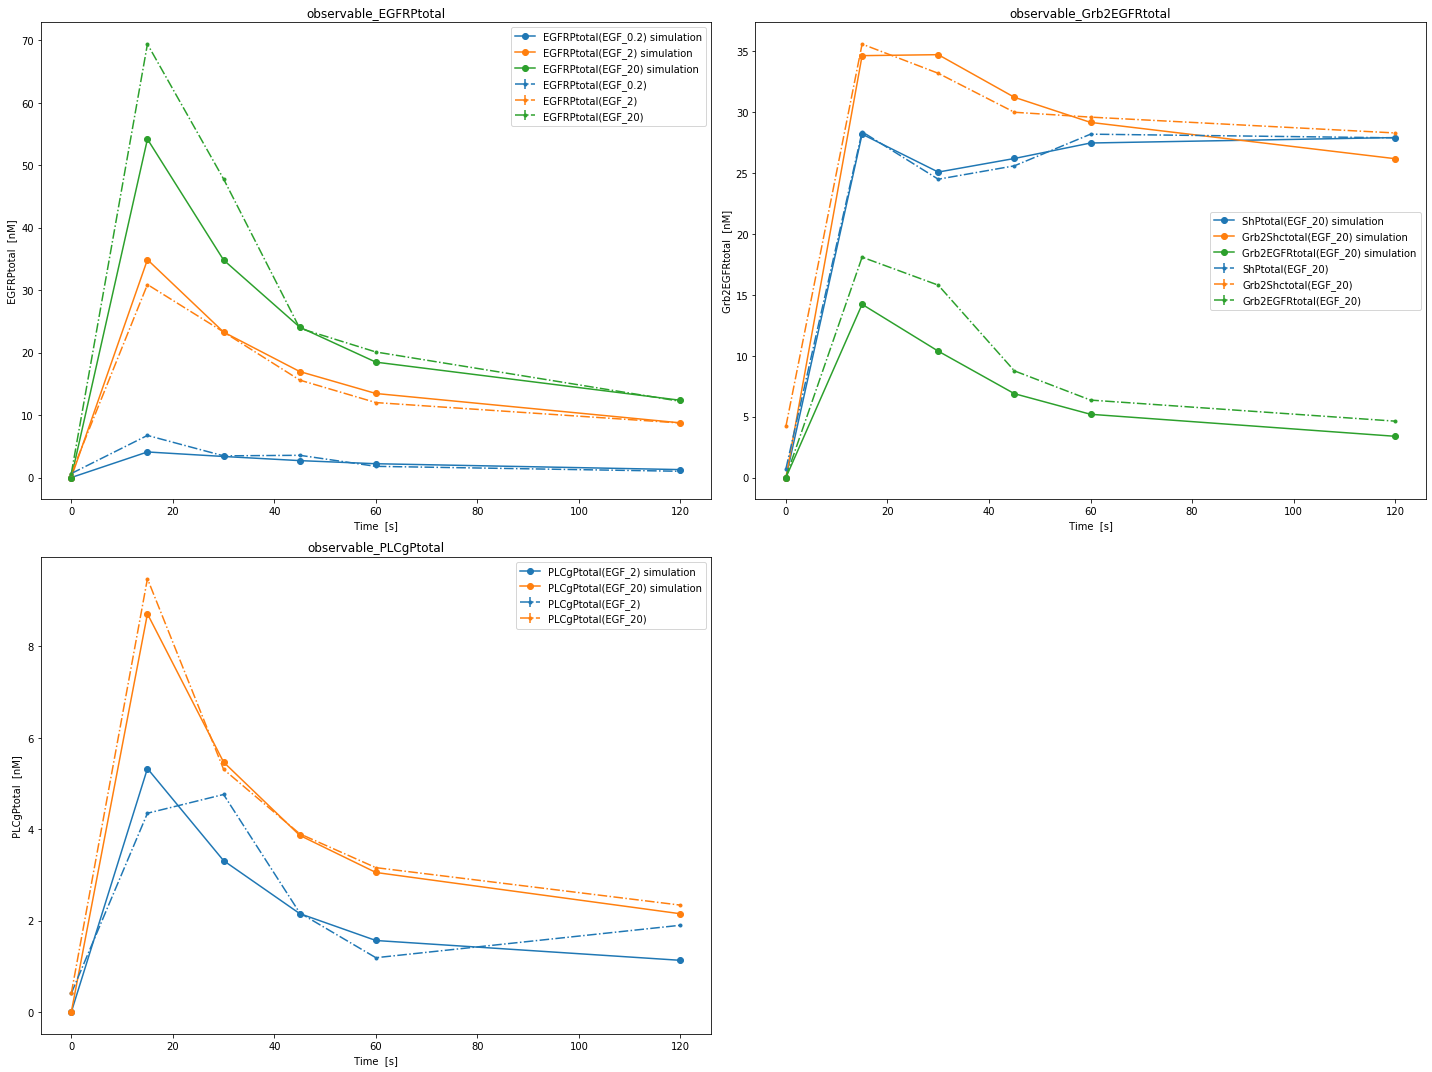

In [5]:
from pypesto.visualize.model_fit import visualize_optimized_model_fit

pp1=visualize_optimized_model_fit(petab_problem=petab_problem, result=result)

In [6]:
def get_x_mle(optimize_result, pypesto_problem, petab_problem, scaled=True):
    if not scaled:
        scaling = petab.parameters.get_optimization_parameter_scaling(
            petab_problem.parameter_df
        )
    return {
        x_id: (
            petab.parameters.unscale(x_value, scaling[x_id])
            if not scaled
            else x_value
        )
        for x_id, x_value in zip(
            pypesto_problem.x_names, optimize_result.list[0]["x"]
        )
        # if x_id in scaling
    }
x_mle_unscaled_original = get_x_mle(
    result.optimize_result,
    problem,
    petab_problem,
    scaled=False,
)
print("Parameters are estimated to be (linear scale):")
print(
    "\n".join(
        [
            f"{x_id}: {x_value}"
            for x_id, x_value in x_mle_unscaled_original.items()
        ]
    )
)

import libsbml

converter_config = libsbml.SBMLLocalParameterConverter().getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled)
)


Using existing amici model in folder /home/zarifeh/Downloads/Energy Modeling/EBM_EStimatedParam_rmulti/amici_models/EBM_EStimatedParam_rmulti.


Parameters are estimated to be (linear scale):
r3_k3f: 0.5066053240582693
r3_k3b: 1.0000000004981075e-05
r4_V4: 1.0000001225618357e-05
r4_K4: 20.8619425587582
r6_k6f: 9.999986154722192
r6_k6b: 1.0395806380953385
r7_k7f: 0.32940206797344757
r7_k7b: 0.9999999999999936
r8_V8: 0.0995976428113968
r8_K8: 1.0000000000000026e-05
r14_k14f: 9.999999999999993
r14_k14b: 1.000000000969513e-05
r15_k15f: 4.9999352226611675
r15_k15b: 0.33842451830718223
r16_V16: 4.676920763990933
r16_K16: 99.99417464042317
r25_k25f: 0.11231275613517369
r25_k25b: 0.011819816597271073
Gf_LR: 9.999766980804123
Gf_RR: 4.931741576136707
Gf_RSh: 0.5920014848986822
Gf_LRR: 1.153456722727831
Gf_LRRL: 1.274786448321655
Gf_RShP: 5.980811674644387
Gf_RG: 5.144868709729761
Gf_GS: -9.986404163747817
Gf_RGS: -3.045385112899916
Gf_ShG: 2.48084205375645
Gf_RShG: -8.092578598749972
Gf_ShGS: -9.999999999999996
Gf_RPL: 3.215185838079518
Gf_RPLP: 9.999999999999998
phi: 0.4729921535719295
Ea_RR: -2.67385836925972
Ea_LR: -9.99999999999999


# Sampling

To evaluate the convergence of MCMC chains it is helpful to create multiple chains that have different starting values. 

In [20]:
import pypesto.sample as sample
sampler = sample.AdaptiveParallelTemperingSampler(
   internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3)

#sampler = sample.AdaptiveMetropolisSampler()

result = sample.sample(
    problem, n_samples=500, sampler=sampler, result=result, filename=None
)


100%|██████████| 500/500 [00:57<00:00,  8.71it/s] 
Elapsed time: 215.2635710049999


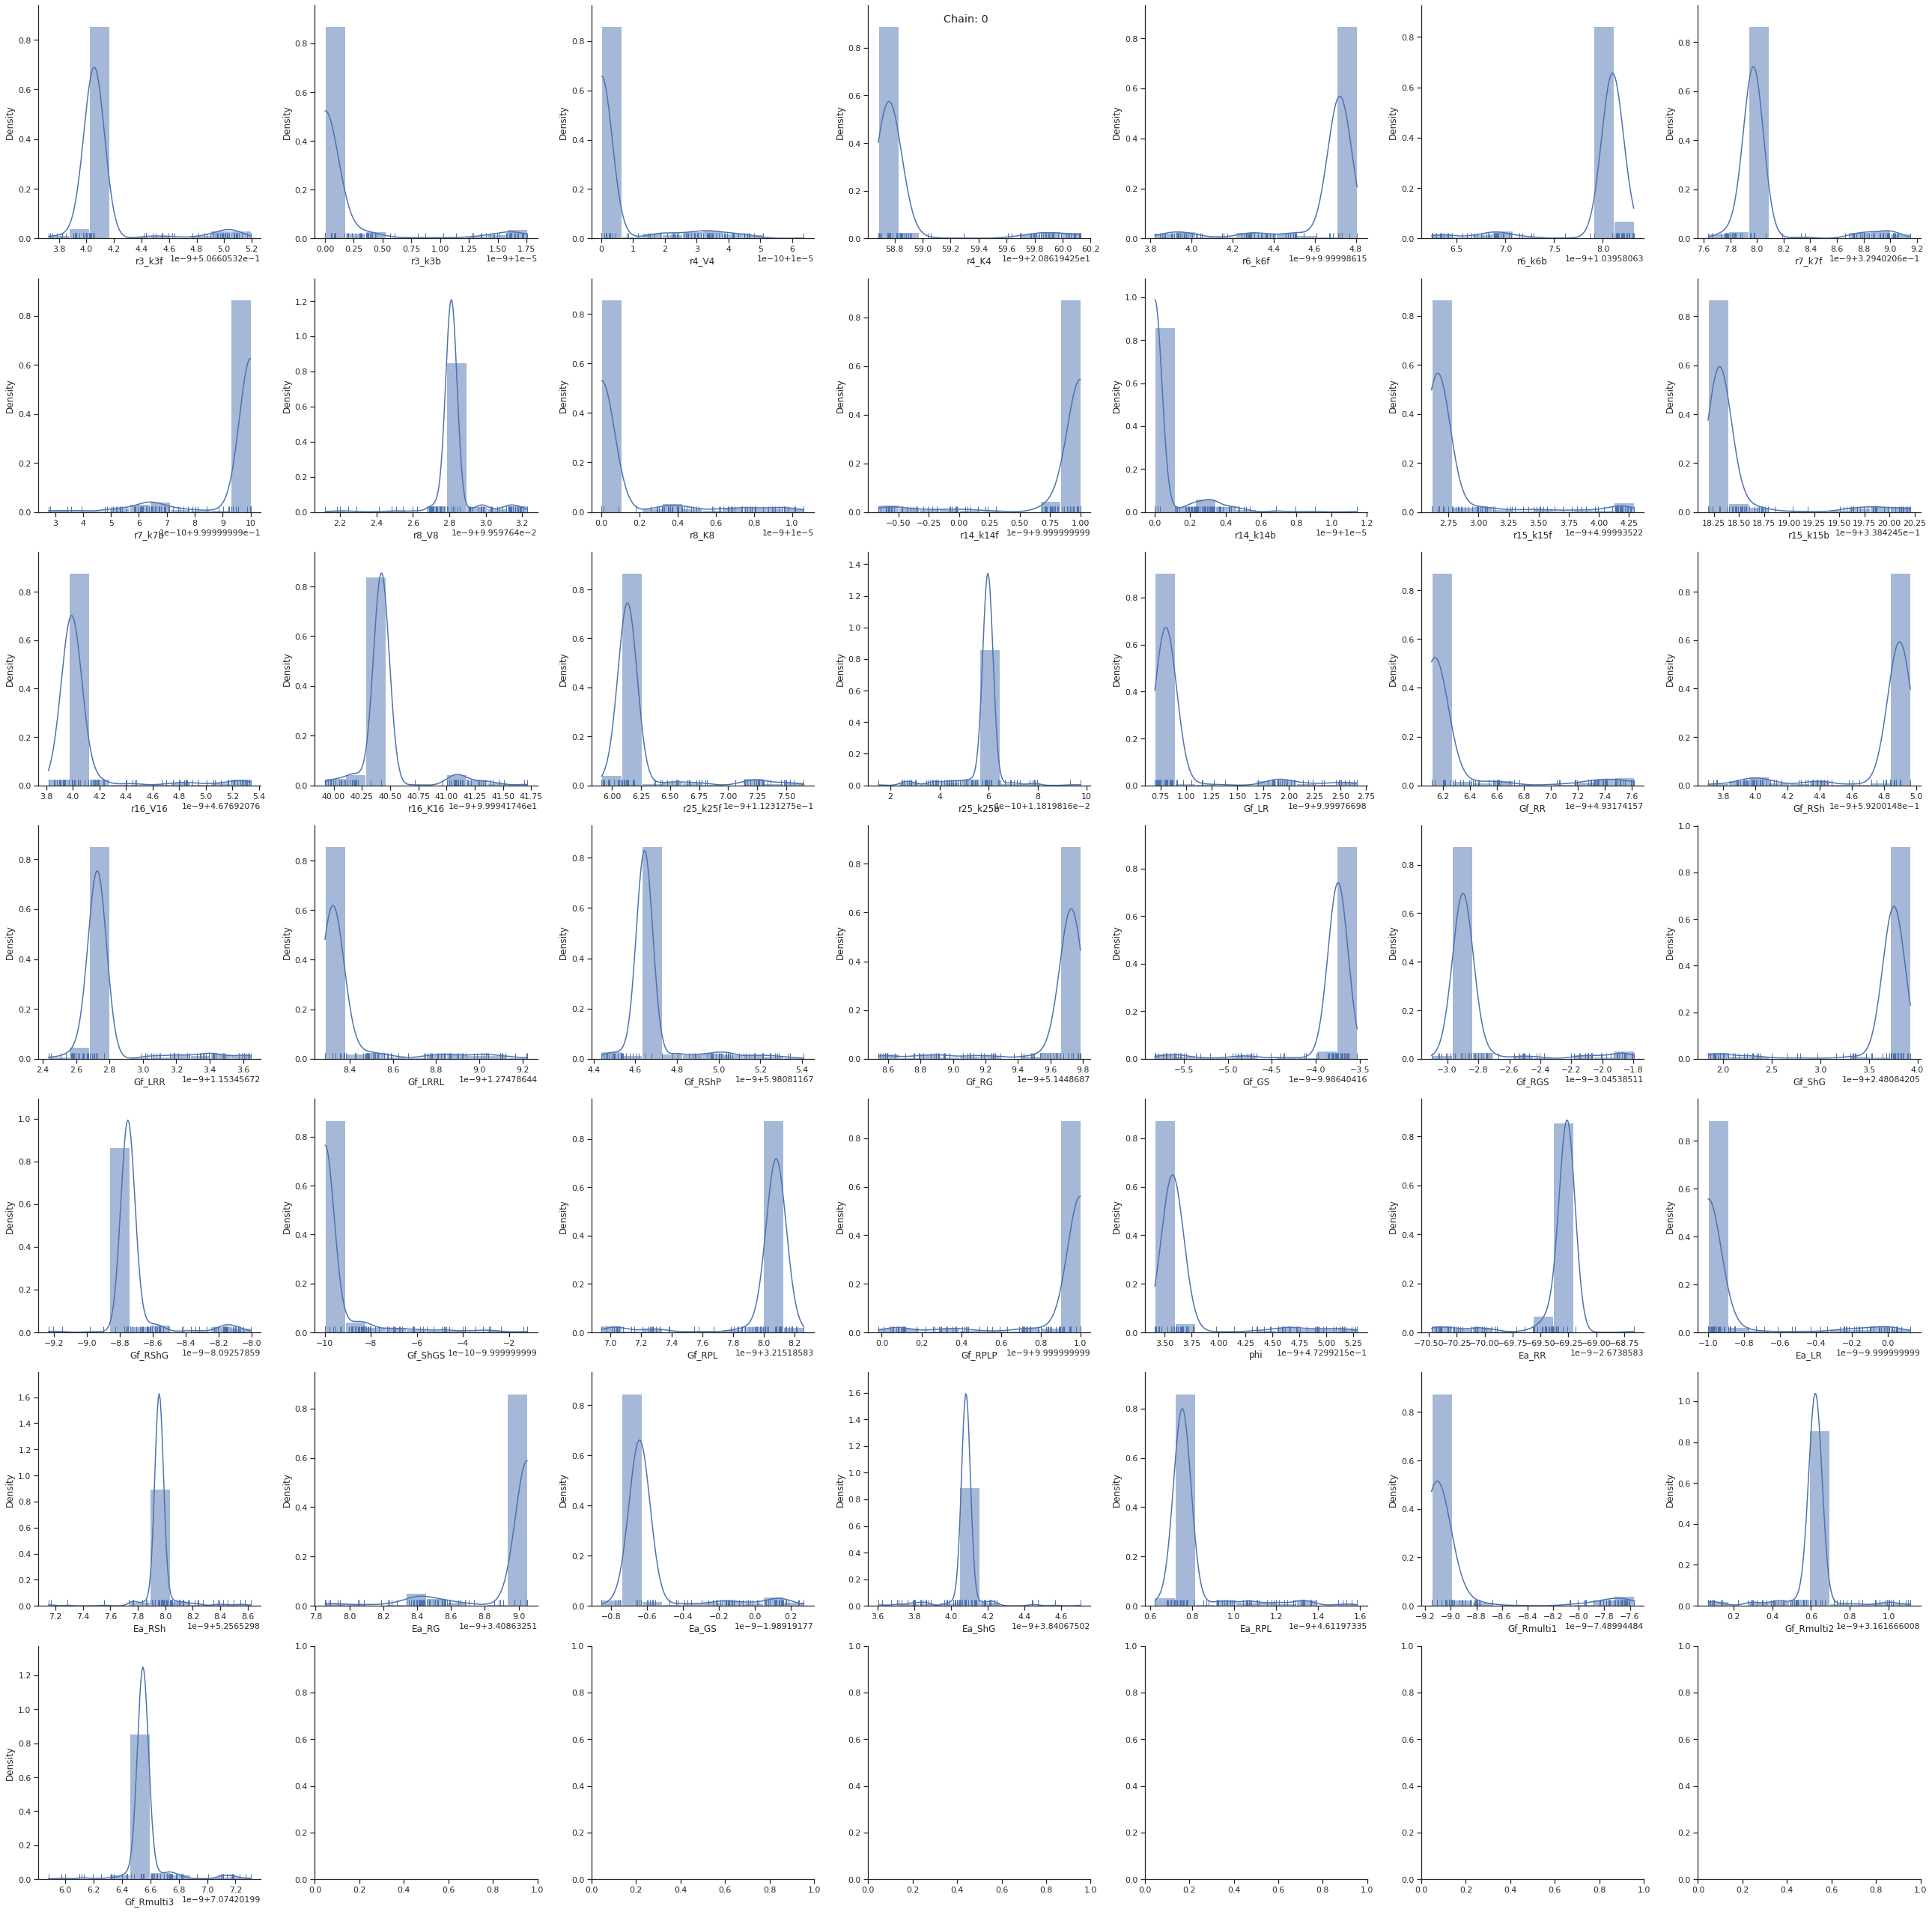

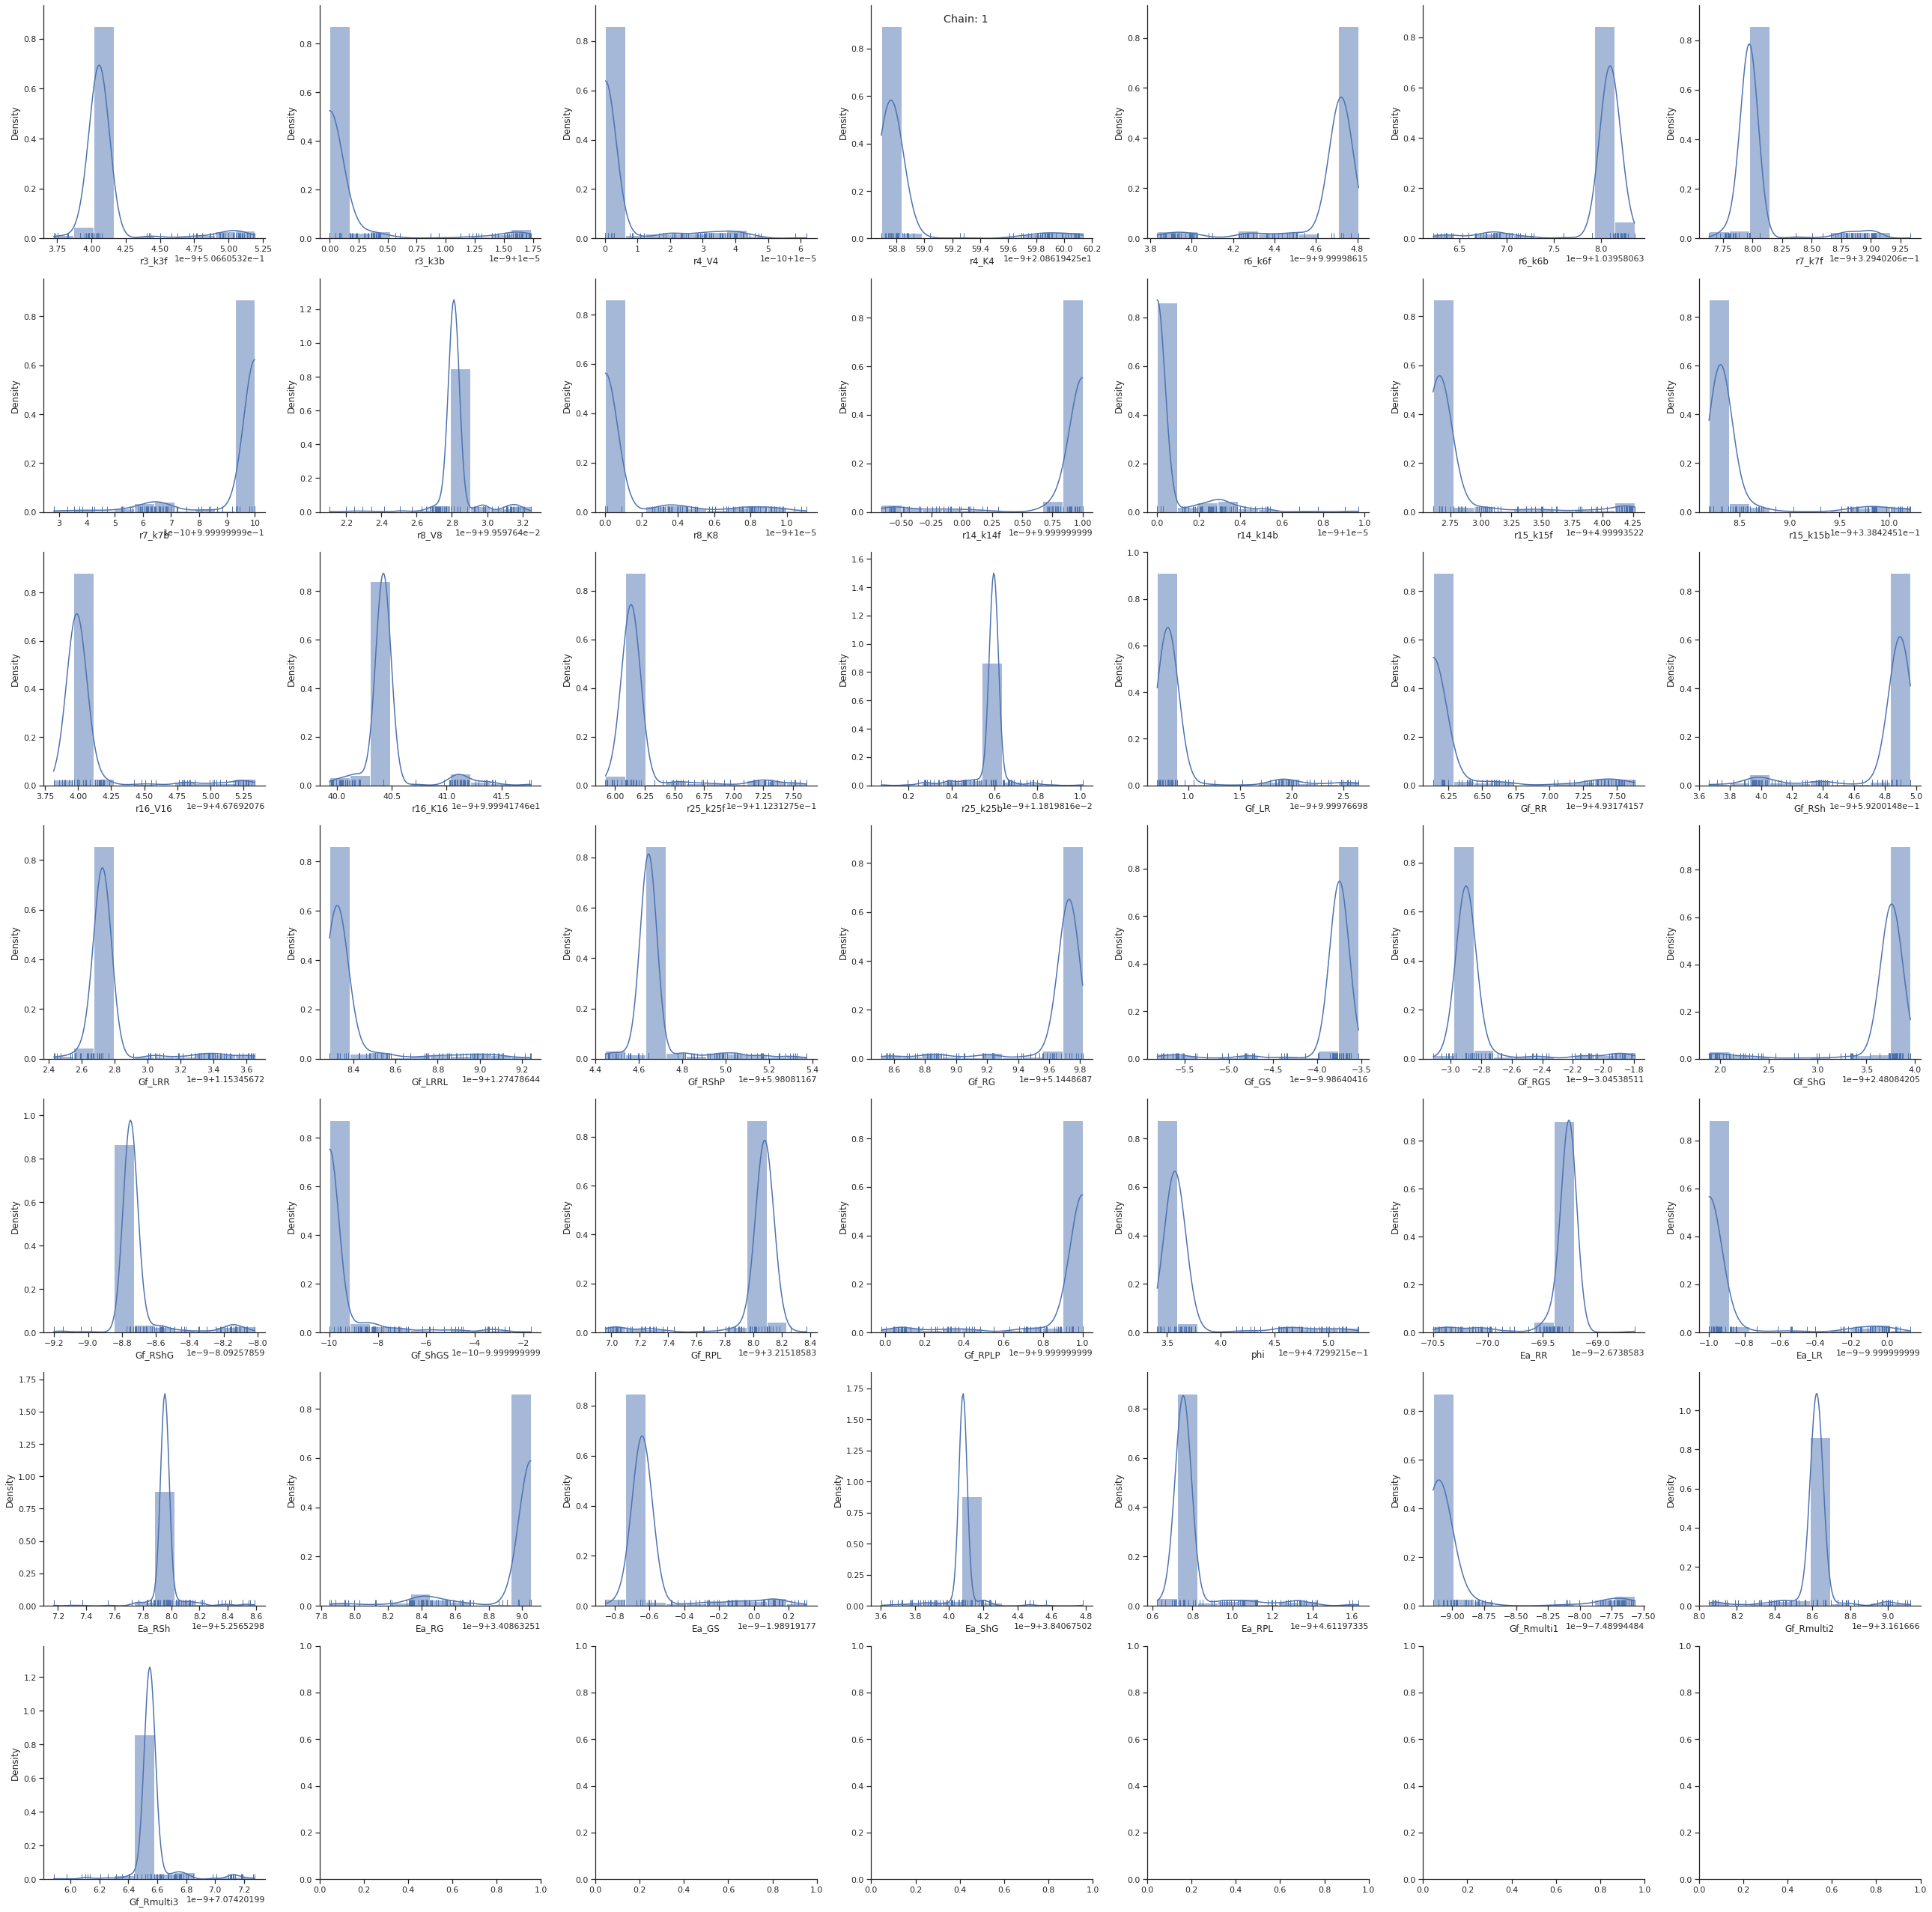

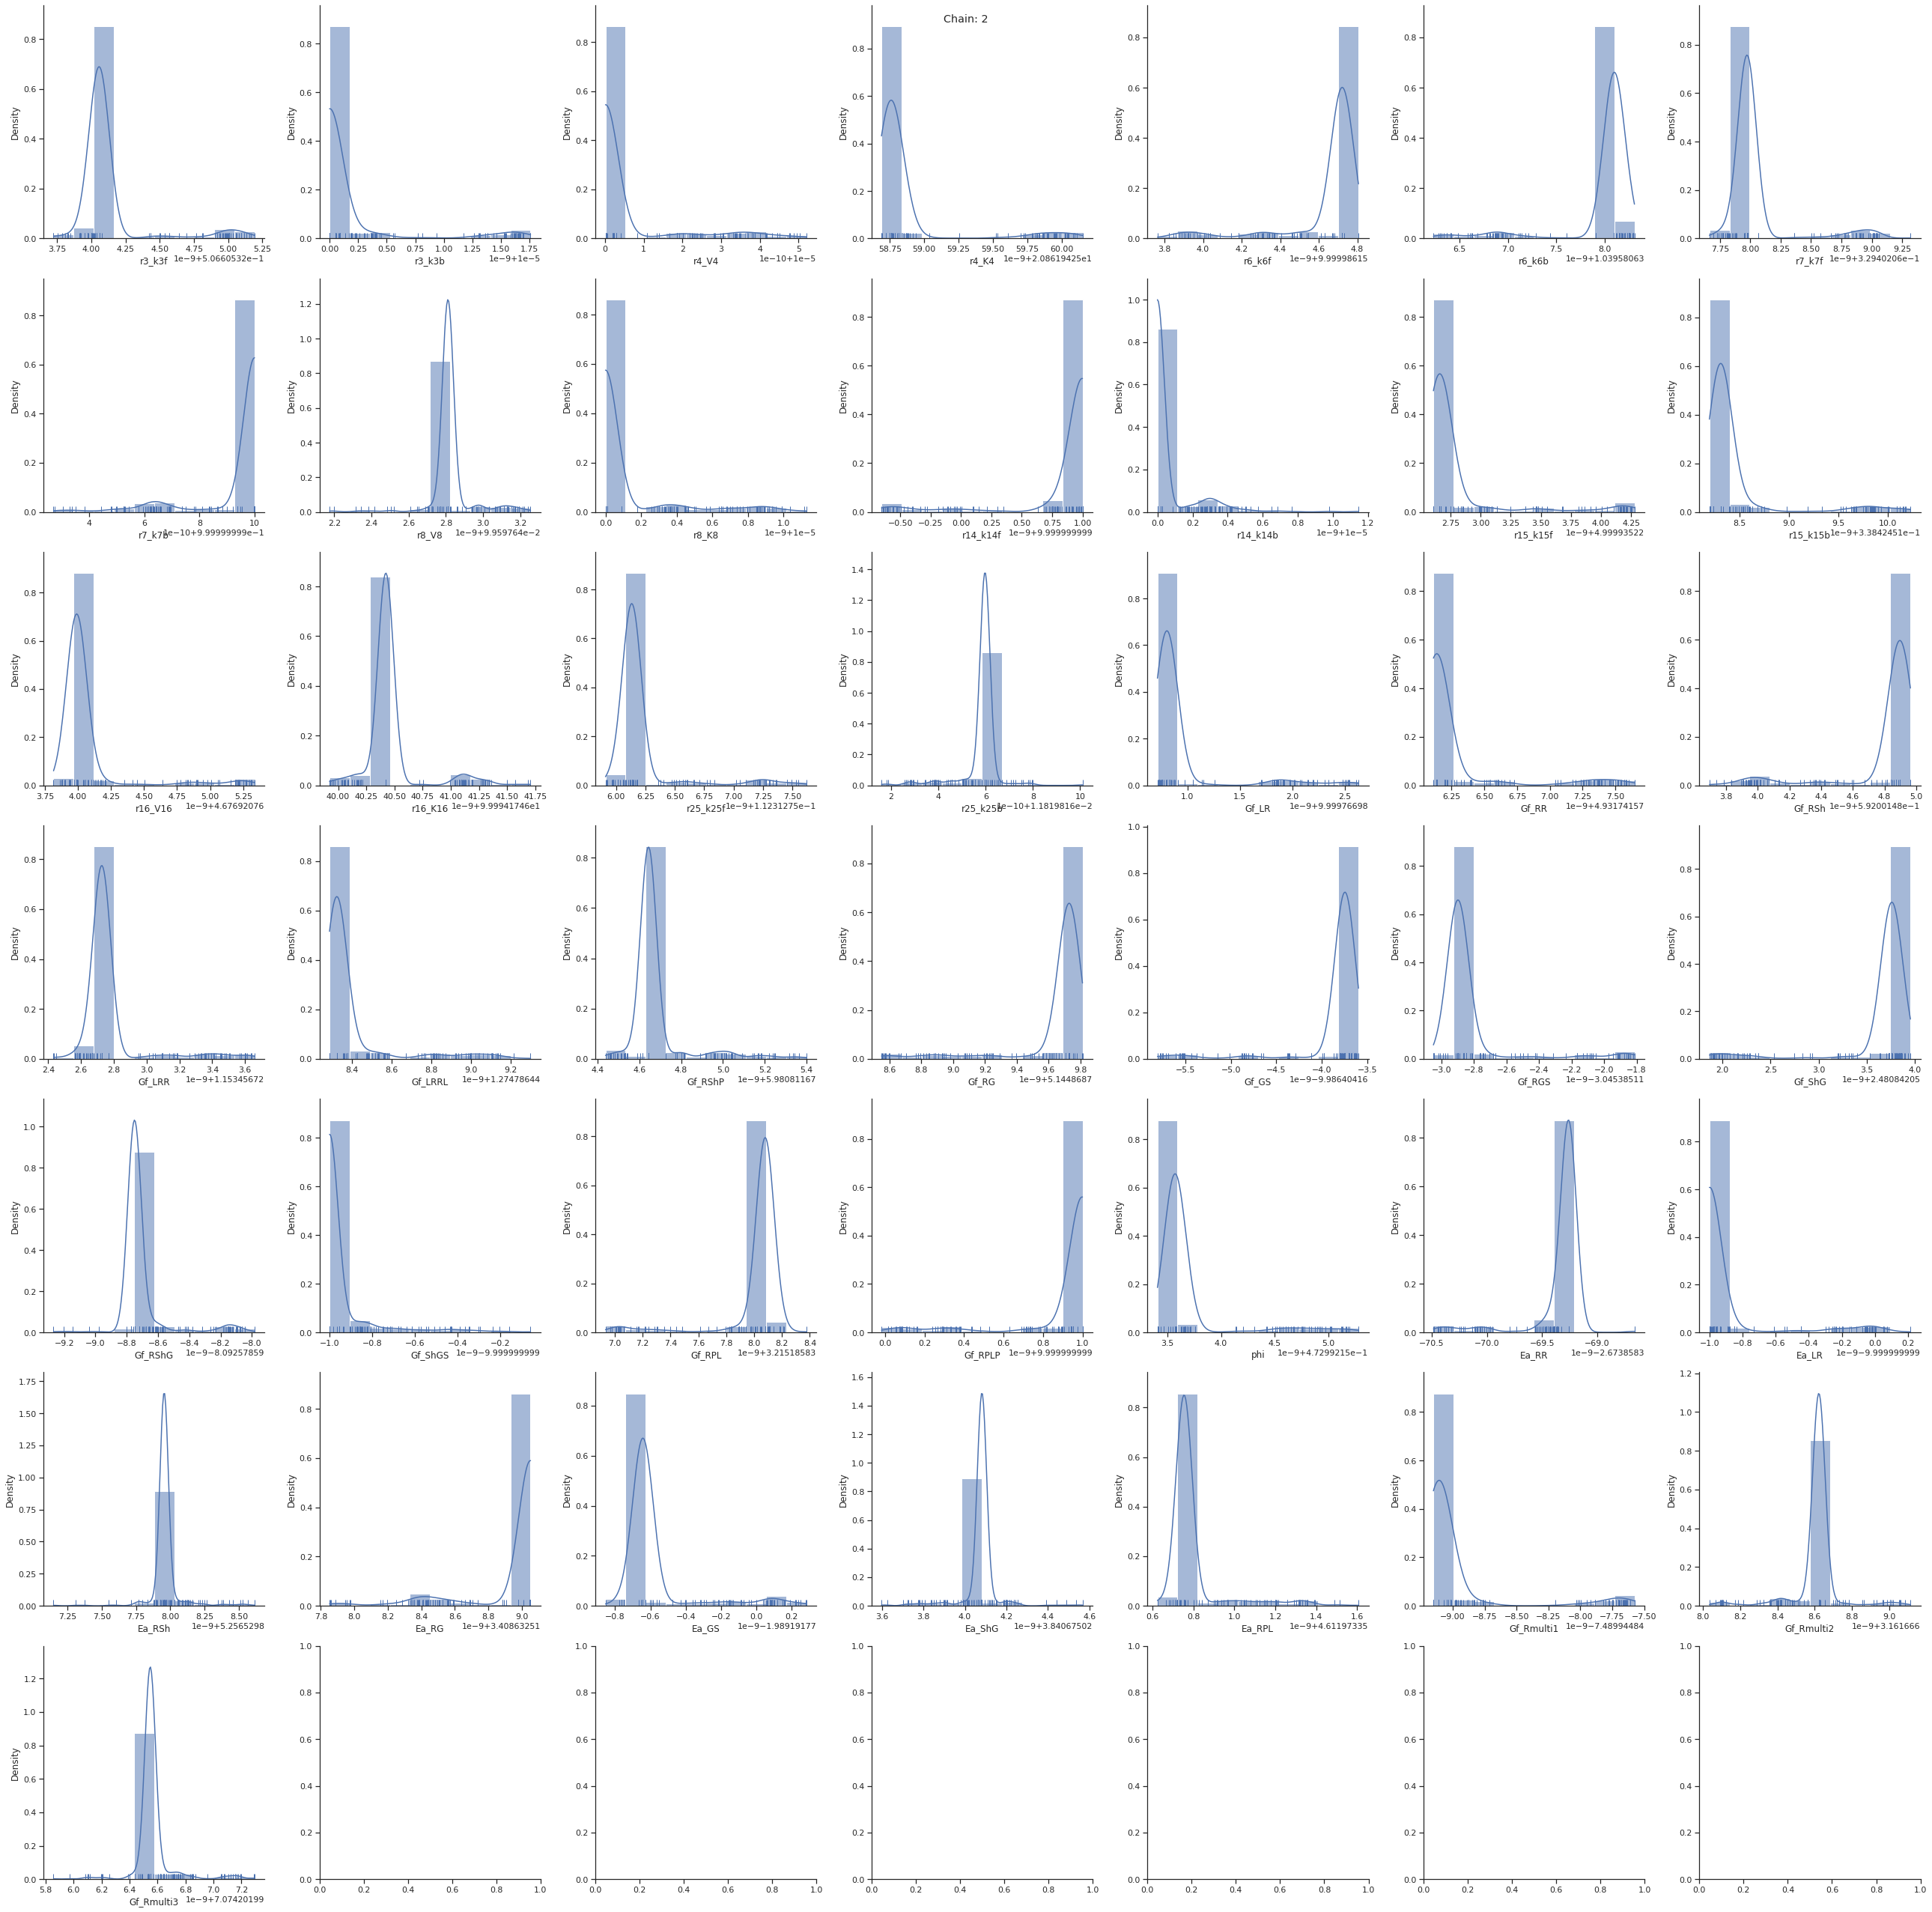

In [21]:
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}", size=(36,36)
    )

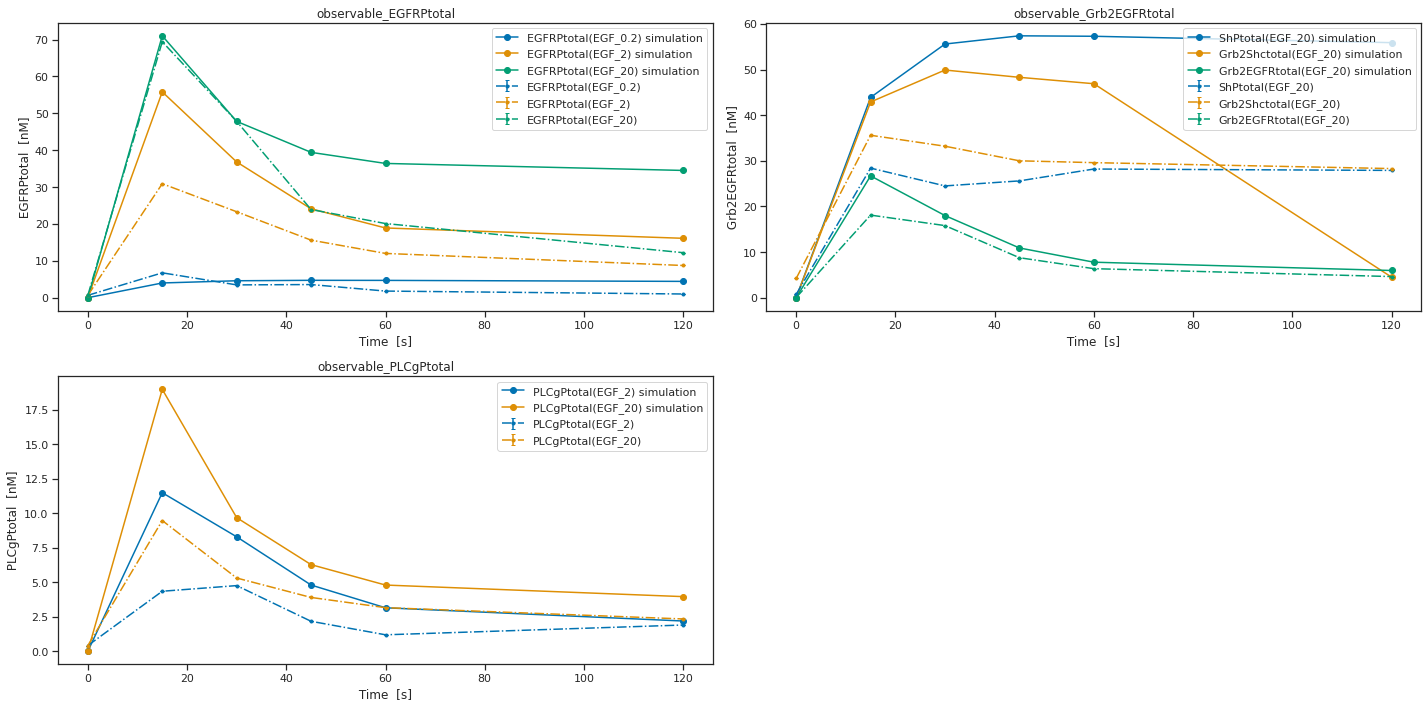

In [29]:
folder = "EGFR/"     #state the exact folder contains .tsv files

data_file_path = folder + "measurementData_EGFR.tsv"
condition_file_path = folder + "experimentalCondition_EGFR.tsv"
visualization_file_path2 = folder + "visualizationSpecification_EGFR.tsv"
simulation_file_path = folder + "simulatedData_EGFR_Kai.tsv"
pp2=petab.visualize.plot_petab_problem(
  petab_problem,
  simulation_file_path,
  data_file_path
)


# Kholodenko's Model Output

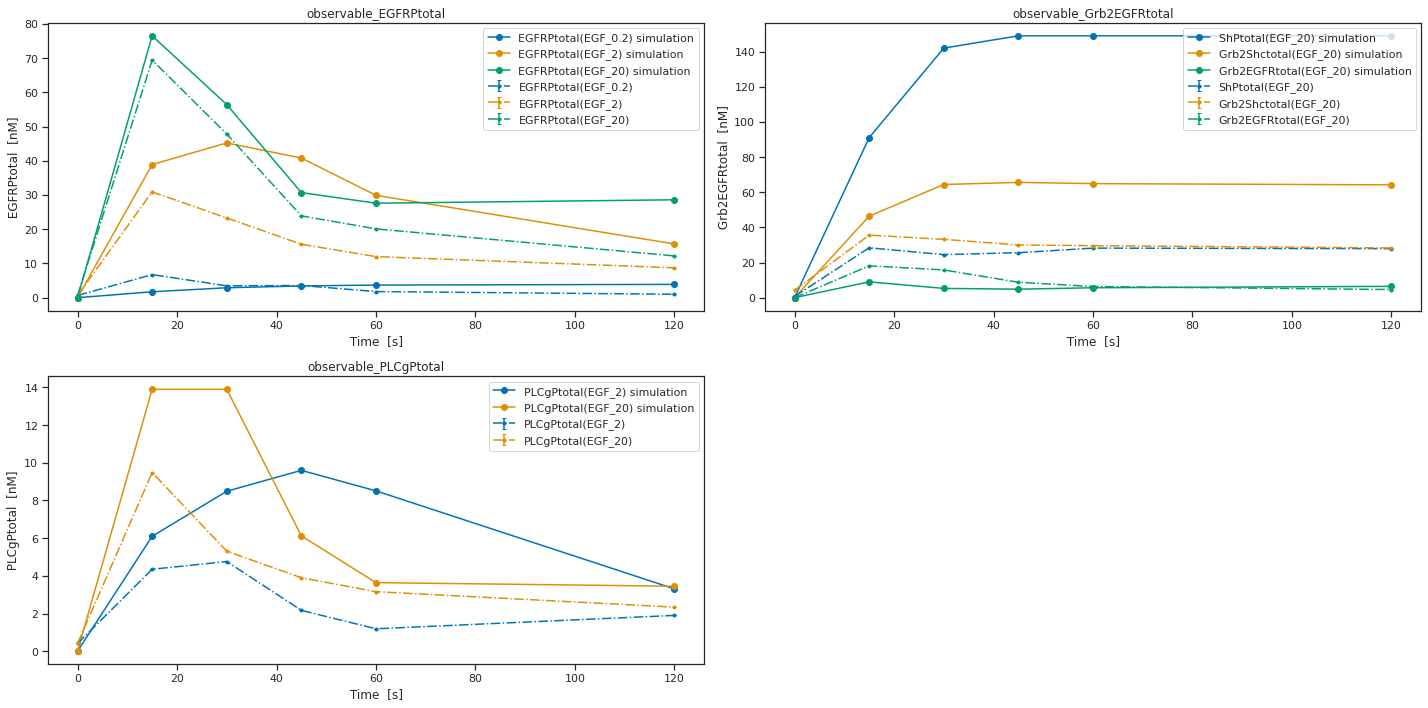

In [27]:
folder = "EGFR/"     #state the exact folder contains .tsv files

data_file_path = folder + "measurementData_EGFR.tsv"
condition_file_path = folder + "experimentalCondition_EGFR.tsv"
visualization_file_path2 = folder + "visualizationSpecification_EGFR.tsv"
simulation_file_path = folder + "simulatedData_EGFR_Kholo.tsv"
pp2=petab.visualize.plot_petab_problem(
  petab_problem,
  simulation_file_path,
  data_file_path
)
